In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score    

In [7]:
data = pd.read_csv('Google_Stock_Price_Train.csv',thousands=',')
data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500
1,1/4/2012,331.27,333.87,329.08,666.45,5749400
2,1/5/2012,329.83,330.75,326.89,657.21,6590300
3,1/6/2012,328.34,328.77,323.68,648.24,5405900
4,1/9/2012,322.04,322.29,309.46,620.76,11688800
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,623400
1254,12/27/2016,790.68,797.86,787.66,791.55,789100
1255,12/28/2016,793.70,794.23,783.20,785.05,1153800
1256,12/29/2016,783.33,785.93,778.92,782.79,744300


Text(0, 0.5, 'Stock Volume')

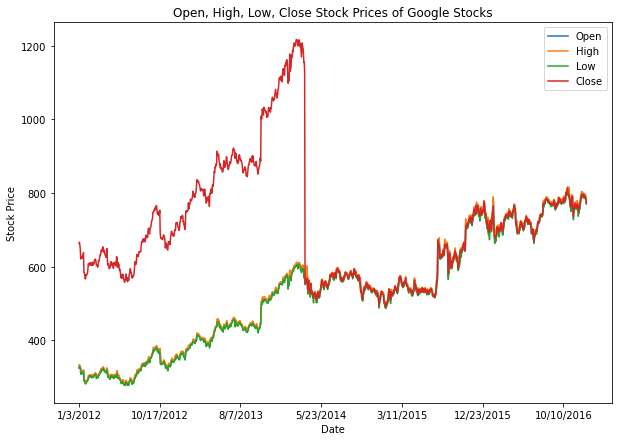

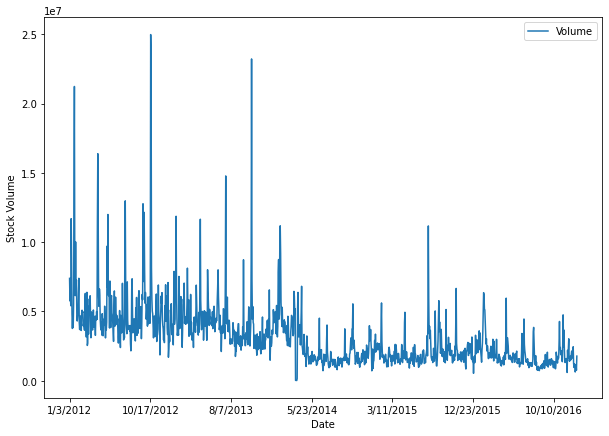

In [8]:
ax1 = data.plot(x="Date", y=["Open", "High", "Low", "Close"], figsize=(10,7),title='Open, High, Low, Close Stock Prices of Google Stocks')
ax1.set_ylabel("Stock Price")

ax2 = data.plot(x="Date", y=["Volume"],  figsize=(10,7))
ax2.set_ylabel("Stock Volume")

In [9]:
data.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

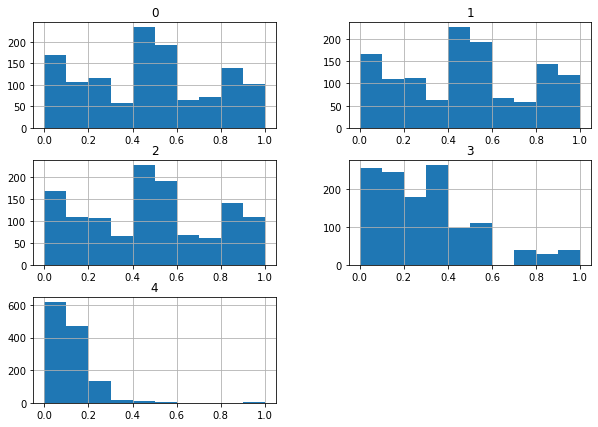

In [10]:
scaler = MinMaxScaler()
data_without_date = data.drop("Date", axis=1)
scaled_data = pd.DataFrame(scaler.fit_transform(data_without_date))
     

scaled_data.hist(figsize=(10,7))
plt.show()

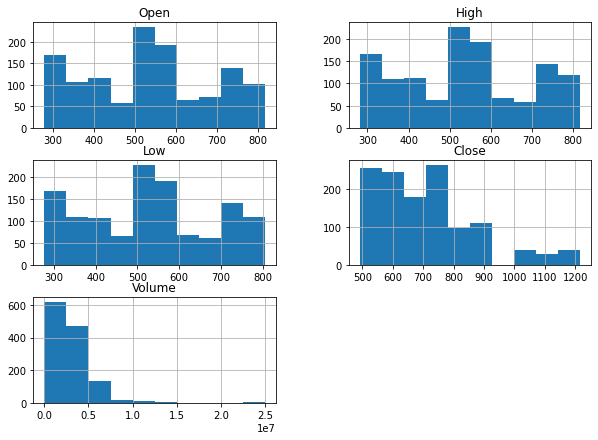

In [11]:
data.hist(figsize=(10,7))
plt.show()

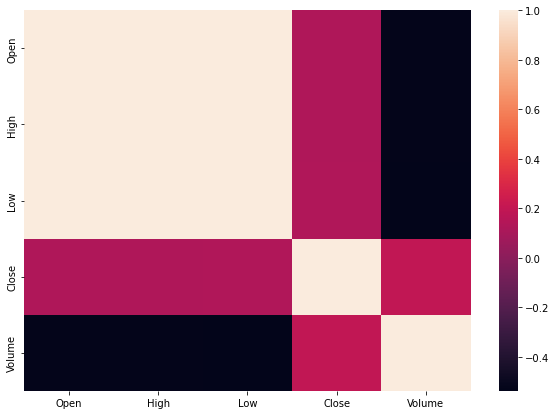

In [12]:
plt.figure(figsize=(10,7))
sns.heatmap(data.drop("Date", axis=1).corr())
plt.show()

In [13]:
scaled_data = scaled_data.drop([0, 2, 3], axis=1)
scaled_data

,1,4
0,0.096401,0.295258
1,0.098344,0.229936
2,0.092517,0.263612
3,0.088819,0.216179
4,0.076718,0.467797
...,...,...
1253,0.955292,0.024650
1254,0.964853,0.031286
1255,0.958074,0.045891
1256,0.942574,0.029491


In [14]:
def split_seq_multivariate(sequence, n_past, n_future):

    '''
    n_past ==> no of past observations
    n_future ==> no of future observations
    '''
    x = []
    y = []
    for window_start in range(len(sequence)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(sequence):
            break
        # slicing the past and future parts of the window (this indexing is for 2 features vala data only)
        past = sequence[window_start:past_end, :]
        future = sequence[past_end:future_end, -1]
        x.append(past)
        y.append(future)

    return np.array(x), np.array(y)
     

n_steps = 60

scaled_data = scaled_data.to_numpy()
scaled_data.shape

(1258, 2)

In [15]:
x, y = split_seq_multivariate(scaled_data, n_steps, 1)
x.shape, y.shape

((1198, 60, 2), (1198, 1))

In [16]:
y = y[:, 0]
y.shape

(1198,)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((958, 60, 2), (240, 60, 2), (958,), (240,))

In [18]:
model = Sequential()
model.add(LSTM(612, input_shape=(n_steps, 2)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1))
     

model.summary()

2025-03-19 11:44:53.927488: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/mmcoe/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 612)            │     1,505,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        30,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,540,281 (5.88 MB)

 Trainable params: 1,540,281 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
     

history = model.fit(x_train, y_train, epochs=250, batch_size=32, verbose=2, validation_data=(x_test, y_test))

Epoch 1/250
30/30 - 6s - 196ms/step - loss: 0.0081 - mae: 0.0560 - val_loss: 0.0058 - val_mae: 0.0408
Epoch 2/250
30/30 - 5s - 155ms/step - loss: 0.0044 - mae: 0.0380 - val_loss: 0.0054 - val_mae: 0.0407
Epoch 3/250
30/30 - 4s - 148ms/step - loss: 0.0043 - mae: 0.0381 - val_loss: 0.0060 - val_mae: 0.0412
Epoch 4/250
30/30 - 5s - 152ms/step - loss: 0.0042 - mae: 0.0357 - val_loss: 0.0048 - val_mae: 0.0370
Epoch 5/250
30/30 - 4s - 148ms/step - loss: 0.0040 - mae: 0.0346 - val_loss: 0.0046 - val_mae: 0.0408
Epoch 6/250
30/30 - 4s - 145ms/step - loss: 0.0040 - mae: 0.0354 - val_loss: 0.0045 - val_mae: 0.0363
Epoch 7/250
30/30 - 4s - 147ms/step - loss: 0.0039 - mae: 0.0356 - val_loss: 0.0043 - val_mae: 0.0374
Epoch 8/250
30/30 - 5s - 154ms/step - loss: 0.0037 - mae: 0.0332 - val_loss: 0.0041 - val_mae: 0.0370
Epoch 9/250
30/30 - 4s - 148ms/step - loss: 0.0038 - mae: 0.0349 - val_loss: 0.0041 - val_mae: 0.0383
Epoch 10/250
30/30 - 4s - 145ms/step - loss: 0.0037 - mae: 0.0335 - val_loss: 0.00

Epoch 81/250
30/30 - 4s - 146ms/step - loss: 0.0030 - mae: 0.0310 - val_loss: 0.0033 - val_mae: 0.0354
Epoch 82/250
30/30 - 4s - 148ms/step - loss: 0.0032 - mae: 0.0315 - val_loss: 0.0037 - val_mae: 0.0358
Epoch 83/250
30/30 - 4s - 146ms/step - loss: 0.0031 - mae: 0.0319 - val_loss: 0.0037 - val_mae: 0.0371
Epoch 84/250
30/30 - 4s - 146ms/step - loss: 0.0031 - mae: 0.0312 - val_loss: 0.0035 - val_mae: 0.0364
Epoch 85/250
30/30 - 4s - 147ms/step - loss: 0.0032 - mae: 0.0318 - val_loss: 0.0036 - val_mae: 0.0346
Epoch 86/250
30/30 - 4s - 145ms/step - loss: 0.0030 - mae: 0.0308 - val_loss: 0.0037 - val_mae: 0.0345
Epoch 87/250
30/30 - 4s - 148ms/step - loss: 0.0031 - mae: 0.0314 - val_loss: 0.0037 - val_mae: 0.0359
Epoch 88/250
30/30 - 4s - 146ms/step - loss: 0.0031 - mae: 0.0321 - val_loss: 0.0040 - val_mae: 0.0359
Epoch 89/250
30/30 - 4s - 146ms/step - loss: 0.0032 - mae: 0.0321 - val_loss: 0.0034 - val_mae: 0.0362
Epoch 90/250
30/30 - 4s - 147ms/step - loss: 0.0031 - mae: 0.0308 - val_l

Epoch 160/250
30/30 - 4s - 149ms/step - loss: 0.0028 - mae: 0.0306 - val_loss: 0.0042 - val_mae: 0.0366
Epoch 161/250
30/30 - 5s - 153ms/step - loss: 0.0028 - mae: 0.0300 - val_loss: 0.0044 - val_mae: 0.0377
Epoch 162/250
30/30 - 4s - 148ms/step - loss: 0.0026 - mae: 0.0288 - val_loss: 0.0041 - val_mae: 0.0376
Epoch 163/250
30/30 - 4s - 147ms/step - loss: 0.0028 - mae: 0.0300 - val_loss: 0.0038 - val_mae: 0.0362
Epoch 164/250
30/30 - 4s - 146ms/step - loss: 0.0033 - mae: 0.0340 - val_loss: 0.0036 - val_mae: 0.0344
Epoch 165/250
30/30 - 4s - 146ms/step - loss: 0.0031 - mae: 0.0308 - val_loss: 0.0039 - val_mae: 0.0368
Epoch 166/250
30/30 - 4s - 150ms/step - loss: 0.0029 - mae: 0.0300 - val_loss: 0.0038 - val_mae: 0.0369
Epoch 167/250
30/30 - 4s - 148ms/step - loss: 0.0029 - mae: 0.0307 - val_loss: 0.0039 - val_mae: 0.0358
Epoch 168/250
30/30 - 4s - 148ms/step - loss: 0.0027 - mae: 0.0294 - val_loss: 0.0039 - val_mae: 0.0379
Epoch 169/250
30/30 - 4s - 147ms/step - loss: 0.0026 - mae: 0.02

Epoch 239/250
30/30 - 5s - 152ms/step - loss: 0.0016 - mae: 0.0257 - val_loss: 0.0054 - val_mae: 0.0405
Epoch 240/250
30/30 - 5s - 151ms/step - loss: 0.0018 - mae: 0.0292 - val_loss: 0.0045 - val_mae: 0.0377
Epoch 241/250
30/30 - 5s - 153ms/step - loss: 0.0027 - mae: 0.0309 - val_loss: 0.0048 - val_mae: 0.0396
Epoch 242/250
30/30 - 5s - 150ms/step - loss: 0.0032 - mae: 0.0323 - val_loss: 0.0040 - val_mae: 0.0363
Epoch 243/250
30/30 - 4s - 148ms/step - loss: 0.0025 - mae: 0.0294 - val_loss: 0.0041 - val_mae: 0.0366
Epoch 244/250
30/30 - 4s - 145ms/step - loss: 0.0020 - mae: 0.0272 - val_loss: 0.0042 - val_mae: 0.0366
Epoch 245/250
30/30 - 4s - 146ms/step - loss: 0.0017 - mae: 0.0255 - val_loss: 0.0046 - val_mae: 0.0387
Epoch 246/250
30/30 - 4s - 145ms/step - loss: 0.0016 - mae: 0.0258 - val_loss: 0.0049 - val_mae: 0.0381
Epoch 247/250
30/30 - 4s - 145ms/step - loss: 0.0015 - mae: 0.0248 - val_loss: 0.0043 - val_mae: 0.0370
Epoch 248/250
30/30 - 4s - 149ms/step - loss: 0.0015 - mae: 0.02

<AxesSubplot:>

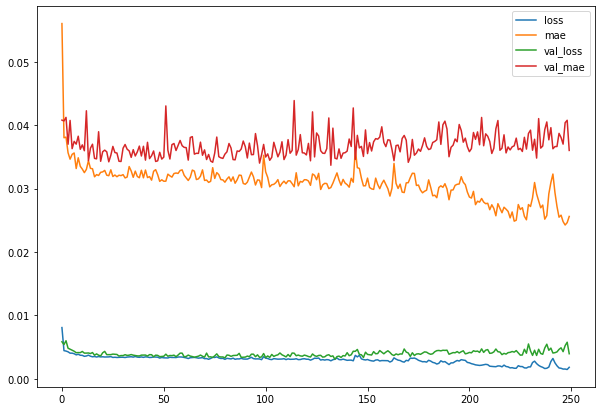

In [20]:
pd.DataFrame(history.history).plot(figsize=(10,7))

In [21]:
model.evaluate(x_test, y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0036 - mae: 0.0355


[0.003925539553165436, 0.036017365753650665]

In [22]:
predictions = model.predict(x_test)
predictions.shape   

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


(240, 1)

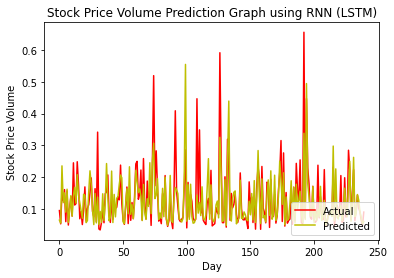

<Figure size 720x504 with 0 Axes>

In [23]:
plt.plot(y_test, c = 'r')
plt.plot(predictions, c = 'y')
plt.xlabel('Day')
plt.ylabel('Stock Price Volume')
plt.title('Stock Price Volume Prediction Graph using RNN (LSTM)')
plt.legend(['Actual','Predicted'], loc = 'lower right')
plt.figure(figsize=(10,7))
plt.show()